# Finding Lane Lines Project

### Import Package

In [15]:
import os, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Loading test images

In [32]:
def present_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

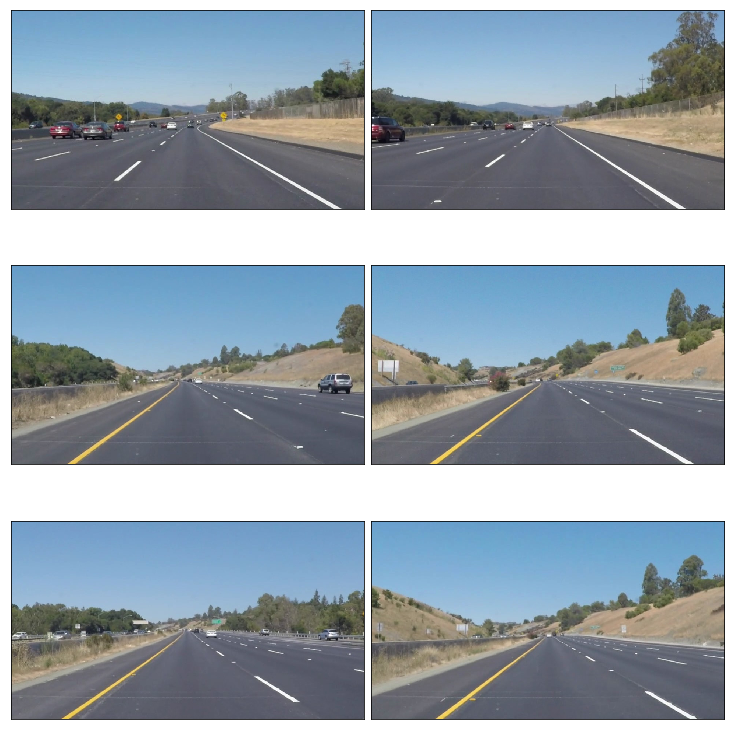

In [33]:
test_files = glob.glob('test_images/*.jpg')
test_images = list(map(mpimg.imread, test_files))

present_images(test_images)

### Converting images to grayscale

In [34]:
def transform_image_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

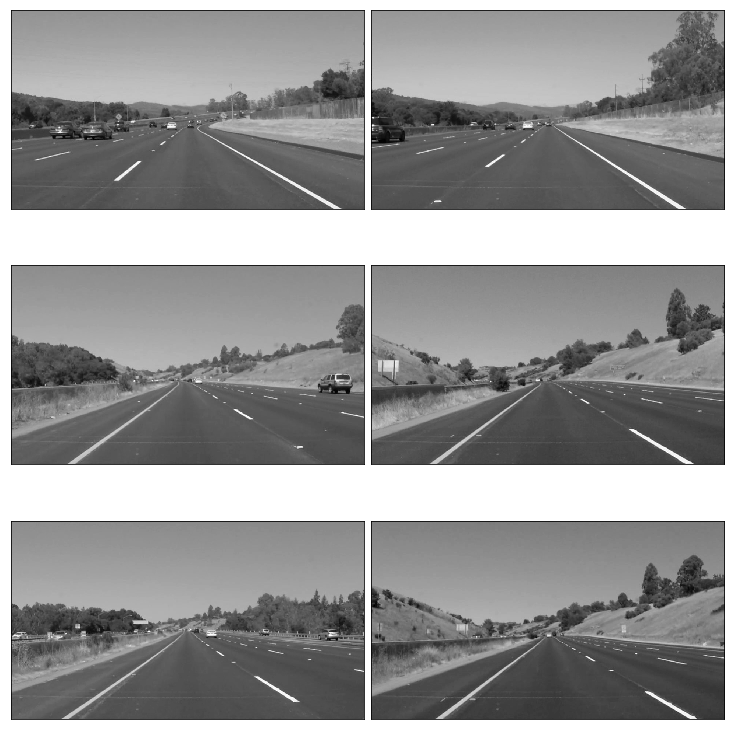

In [35]:
gray_images = list(map(transform_image_to_grayscale, test_images))

present_images(gray_images)

### Making image smoother

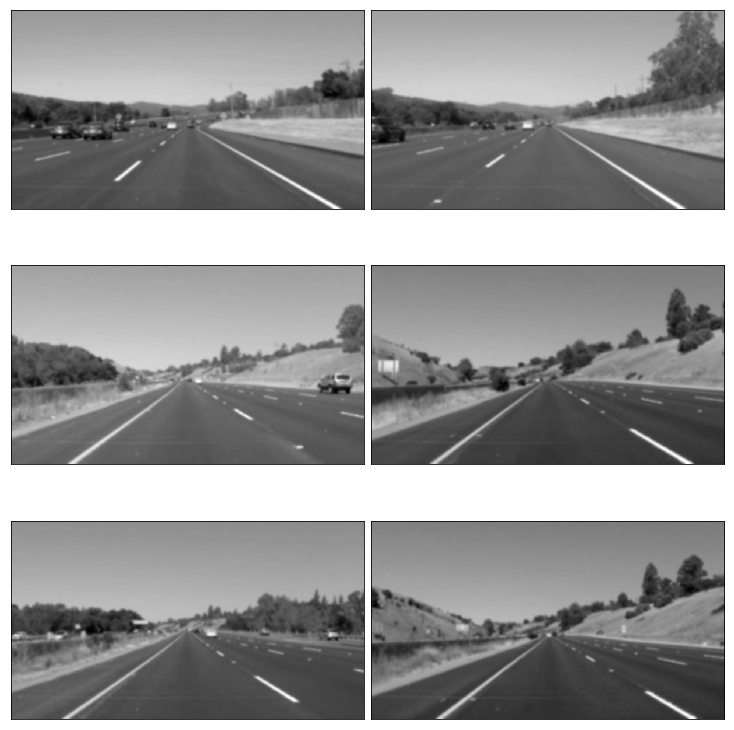

In [36]:
def blur_image(img, kernel_size=15):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

blurred_images = list(map(blur_image, gray_images))
present_images(blurred_images)

### Extracting edges from image

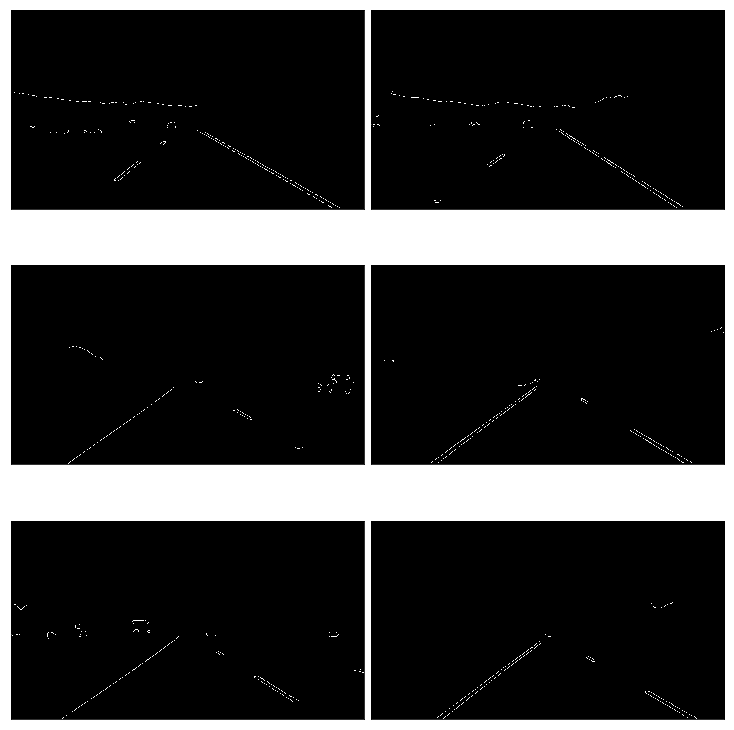

In [39]:
def extract_edges_from_image(img, low_threadhold=50, high_threadhold=150):
    return cv2.Canny(img, low_threadhold, high_threadhold)

edge_extracted_images = list(map(extract_edges_from_image, blurred_images))
present_images(edge_extracted_images)

### Adding Mask of Interest Region

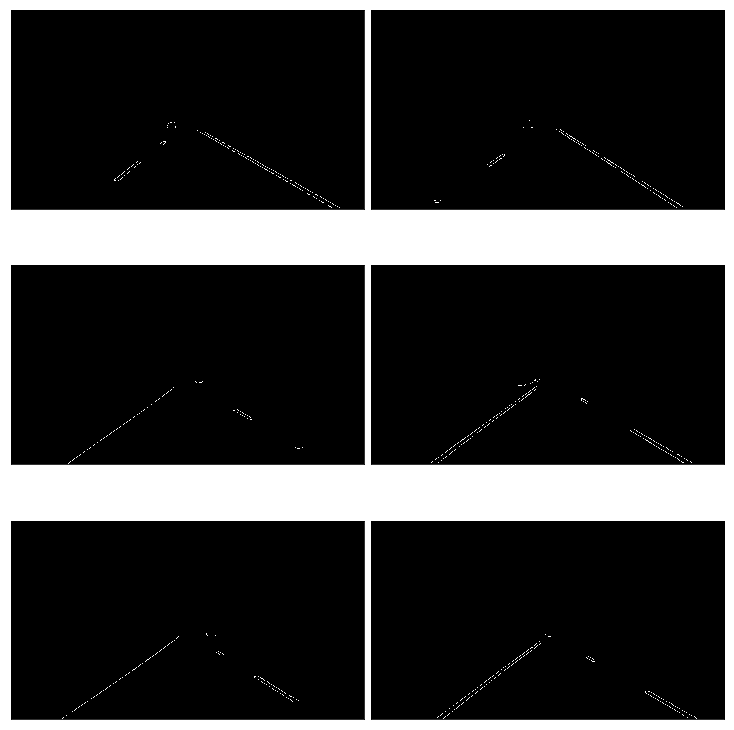

In [41]:
def add_mask_to_image(img, vertices):
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    return cv2.bitwise_and(img, mask)
  
def vertices_for_img(img):
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    left_top = (xsize/2, ysize/2)
    left_bottom = (0,ysize)
    right_top = (xsize/2, ysize/2)
    right_bottom = (xsize,ysize)
    
    return np.array([[left_bottom,left_top,right_top,right_bottom]], dtype=np.int32)

vertices = list(map(vertices_for_img, edge_extracted_images))
masked_edge_images = list(map(add_mask_to_image, edge_extracted_images, vertices))

present_images(masked_edge_images)

### Appling Hough Lines Algorithm

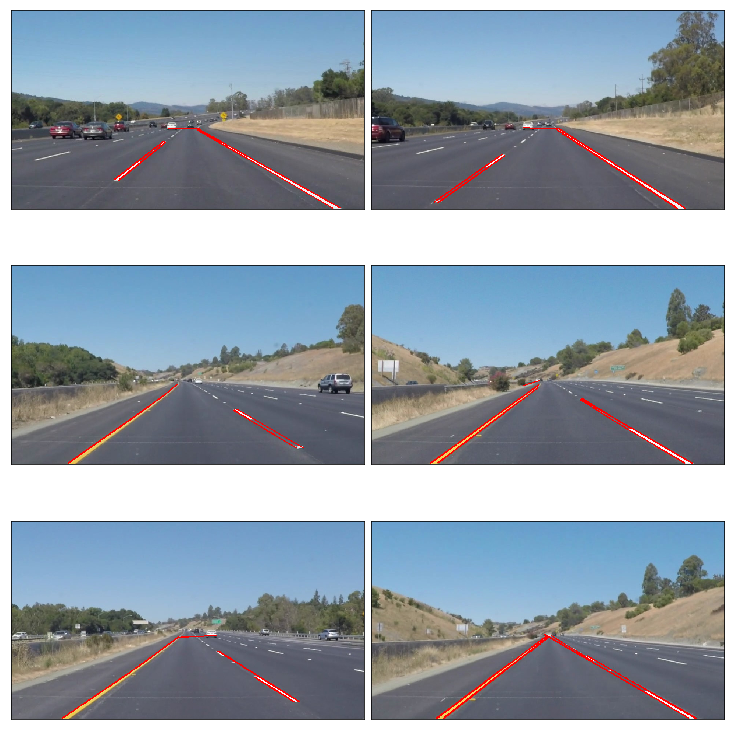

In [48]:
def hough_lines(img):
    return cv2.HoughLinesP(img,rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    img = np.copy(img)# don't want to change the original image
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1,y1), (x2,y2), color, thickness)
    return img

list_of_lines = list(map(hough_lines, masked_edge_images))
line_detected_images = list(map(draw_lines, test_images, list_of_lines))

present_images(line_detected_images)

### Averaging/Extrapolating Lines

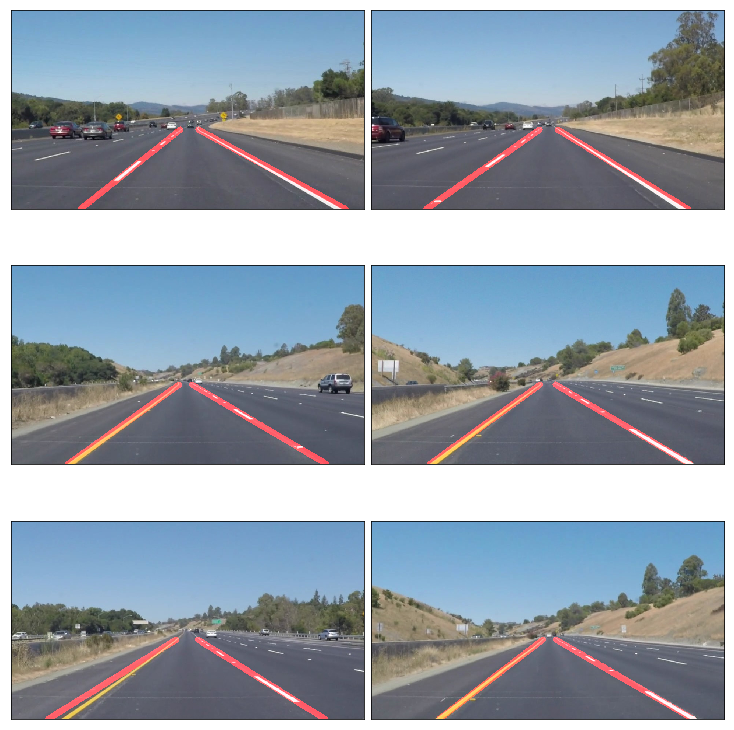

In [70]:
def calculate_average_lane_lines(image, lines):
    left_lane, right_lane = calculate_average_slop_intercept(lines)
    
    y1 = image.shape[0]
    y2 = y1*0.6
    
    left_line = convert_line_into_pixel(y1, y2, left_lane)
    right_line = convert_line_into_pixel(y1, y2, right_lane)
    
    return left_line, right_line

def calculate_average_slop_intercept(lines):
    left_lines = []
    left_weights = []
    right_lines = []
    right_weights = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue
                
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            distance = np.sqrt(((y2-y1)**2) + ((x2-x1)**2))
            
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append(distance)
            else:
                right_lines.append((slope, intercept))
                right_weights.append(distance)

    if len(left_weights) > 0:
        left_lane = np.dot(left_weights, left_lines)/np.sum(left_weights)
    
    if len(right_weights) > 0:
        right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights)
        
    return left_lane, right_lane

def convert_line_into_pixel(y1, y2, line):
    if line is None:
        return None
    
    slope, intercept = line
    
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

def draw_extrapolated_lane_lines(image, lines, color=[255, 0, 0], thickness=15):
    line_image = np.zeros_like(image)
    
    for line in lines:
        if line is None:
            continue
        cv2.line(line_image, *line, color, thickness)

    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)


final_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_lines = calculate_average_lane_lines(image, lines)
    lane_images = draw_extrapolated_lane_lines(image, lane_lines)
    final_images.append(lane_images)
    
present_images(final_images)

### Lane dectection on Video clips

In [71]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [82]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    gray_image = transform_image_to_grayscale(image)
    blurred_image = blur_image(gray_image) 
    edge_extracted_image = extract_edges_from_image(blurred_image)
    
    vertices = vertices_for_img(edge_extracted_image)
    masked_edge_image = add_mask_to_image(edge_extracted_image, vertices)

    lines = hough_lines(masked_edge_image)
    line_detected_image = draw_lines(image, lines)
    
    lane_lines = calculate_average_lane_lines(image, lines)
    result = draw_extrapolated_lane_lines(image, lane_lines)
    
    return result

### 1st Ouput

In [83]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:02<00:00, 46.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.17 s, sys: 506 ms, total: 2.67 s
Wall time: 3.38 s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### 2nd Output

In [85]:
white_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
white_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 99%|█████████▉| 125/126 [00:02<00:00, 43.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2.22 s, sys: 543 ms, total: 2.76 s
Wall time: 3.56 s


In [86]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))